### Import

In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import time
import sys
import imageio
import pickle
import json
import visualkeras
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tqdm import tqdm
from PIL import Image
from sklearn.decomposition import PCA
from keras.models import Model
from keras.layers import Input, Reshape, Dense, Flatten
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses

### Fonts

In [21]:
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Helvetica'}

### Classes

In [22]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Create Dataset from Image Directories

In [23]:
train_dir = '../../data/cifar10/images/train/'
validation_dir = '../../data/cifar10/images/val/'
BATCH_SIZE = 32
IMG_SIZE = (64, 64)
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                       shuffle=True,
                                                       batch_size=BATCH_SIZE,
                                                       image_size=IMG_SIZE)

validation_ds = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 50000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.


### Visualize as sanity check

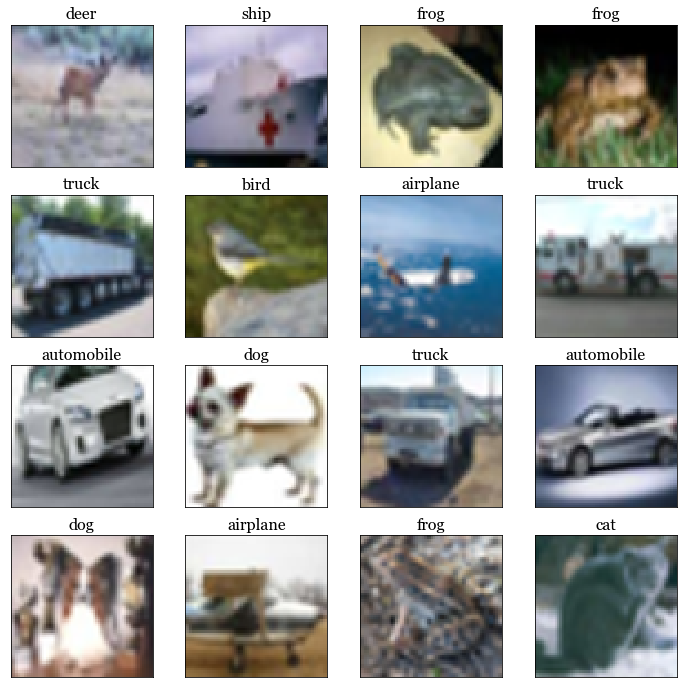

In [24]:
plt.figure(figsize=(12,12));
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"),interpolation='nearest')
        plt.title(classes[labels[i]],**csfont,fontsize=16)
        plt.xticks([]);
        plt.yticks([]);

### Create Test Data set

In [25]:
val_batches = tf.data.experimental.cardinality(validation_ds)
test_ds = validation_ds.take(val_batches // 5)
validation_ds = validation_ds.skip(val_batches // 5)

### Some numbers

In [26]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of train batches: 1563
Number of validation batches: 251
Number of test batches: 62


### Preprocessing

In [27]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./255.0, offset=0)

### Model Implementation

In [28]:
model=keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(64,64,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10,activation='softmax')])

### Optimizer

In [30]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.002,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam')

### Add Preprocessing to Model Pipeline

In [31]:
inputs = tf.keras.Input(shape=(64, 64, 3))
x = preprocess_input(inputs)
x = rescale(x)
outputs = model(x, training=False)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 64, 64, 3)        0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 64, 64, 3)        0         
 bda)                                                            
                                                                 
 rescaling_1 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 10)                2162186   
                                                                 
Total params: 2,162,186
Trainable params: 2,159,946
Non-tra

### Compile

In [32]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

### Fit

In [33]:
history = model.fit(train_ds, epochs=40, validation_data=test_ds, validation_freq=1)

Epoch 1/40
1563/1563 [==============================] - 82s 52ms/step - loss: 1.9034 - accuracy: 0.2756 - val_loss: 1.6163 - val_accuracy: 0.3967
Epoch 2/40
1563/1563 [==============================] - 83s 53ms/step - loss: 1.4894 - accuracy: 0.4508 - val_loss: 1.4138 - val_accuracy: 0.4975
Epoch 3/40
1563/1563 [==============================] - 89s 57ms/step - loss: 1.3223 - accuracy: 0.5226 - val_loss: 1.2818 - val_accuracy: 0.5464
Epoch 4/40
1563/1563 [==============================] - 85s 54ms/step - loss: 1.2143 - accuracy: 0.5625 - val_loss: 1.2453 - val_accuracy: 0.5559
Epoch 5/40
1563/1563 [==============================] - 85s 54ms/step - loss: 1.1290 - accuracy: 0.5971 - val_loss: 1.2082 - val_accuracy: 0.5796
Epoch 6/40
1563/1563 [==============================] - 84s 53ms/step - loss: 1.0562 - accuracy: 0.6271 - val_loss: 1.1458 - val_accuracy: 0.5817
Epoch 7/40
1563/1563 [==============================] - 92s 59ms/step - loss: 0.9811 - accuracy: 0.6539 - val_loss: 1.1807 -

### Save Model

In [17]:
model.save('../../models/alexnet_cifar10_64x64')

2022-08-28 22:29:42.054212: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../../models/alexnet_cifar10_64x64/assets


### Predict

In [19]:
for images, labels in test_ds.take(1):
    test_images = images.numpy()
    test_labels = labels.numpy()
y_pred = model.predict(test_images)
y_pred = np.argmax(y_pred,axis=1)
y_pred = np.expand_dims(y_pred,-1)
C = confusion_matrix(test_labels,y_pred);

### Plot Result

In [1]:
plt.figure(figsize=(14,4))
plt.subplots_adjust(left=0.0,bottom=0, right=1.0, top=1, wspace=0.2, hspace=0)
plt.subplot(1,3,1);
plt.plot(history.history['accuracy'], c='k',label='accuracy')
plt.plot(history.history['val_accuracy'],c='r', label = 'validation accuracy')
plt.xlabel('Epoch',**csfont,fontsize=20)
plt.ylabel('Loss',**csfont,fontsize=20)
plt.yticks(np.linspace(0,1,11),np.round(np.linspace(0,1,11),2).astype(float),**csfont,fontsize=16)
plt.xticks(np.linspace(0,20,11),np.linspace(0,20,11).astype(int),**csfont,fontsize=16)
plt.grid()
plt.legend(loc='lower right',frameon=False);
plt.subplot(1,3,2);
plt.plot(history.history['loss'], c='k', label='loss')
plt.plot(history.history['val_loss'], c='r',label = 'validation loss')
plt.xlabel('Epoch',**csfont,fontsize=20)
plt.ylabel('Loss',**csfont,fontsize=20)
plt.yticks(np.linspace(0,2,11),np.round(np.linspace(0,2,11),2).astype(float),**csfont,fontsize=16)
plt.xticks(np.linspace(0,50,11),np.linspace(0,50,11).astype(int),**csfont,fontsize=16)
plt.grid()
plt.legend(loc='upper right',frameon=False);
plt.subplot(1,3,3);
plt.imshow(C,cmap='gray');
plt.xlabel('Predicted Digit',**csfont,fontsize=20);
plt.ylabel('Actual Digit',**csfont,fontsize=20);
plt.xticks(np.linspace(0,9,10),np.linspace(0,9,10).astype(int),**csfont,fontsize=16);
plt.yticks(np.linspace(0,9,10),np.linspace(0,9,10).astype(int),**csfont,fontsize=16);
plt.savefig('../../assets/matplotlib/26-alexnet-64x64-cifar10.png', dpi=300,bbox_inches="tight")    

NameError: name 'plt' is not defined

### 1st Convolutional Layer Filters

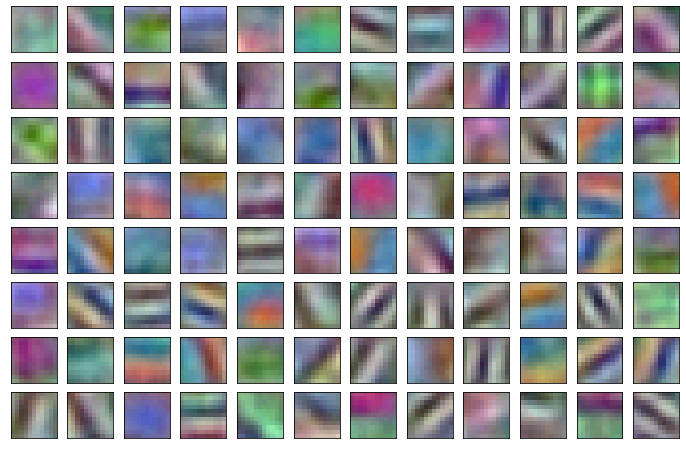

In [21]:
Conv0 = model.layers[0].get_weights()[0]
plt.figure(figsize=(12,12))
for i in range(Conv0.shape[3]):
    plt.subplot(12,12,i+1)
    max_amplitude = np.max(np.abs(Conv0))
    myfilter = (Conv0[:,:,:,i] / max_amplitude * 0.5) + 0.5
    plt.imshow(myfilter,interpolation='nearest');
    plt.xticks([])
    plt.yticks([])    